# Usage

Below is an example workflow using `airbnb_prediction`:

## Import

In [1]:
import airbnb_prediction as air

## Summary

`airbnb_predict` can be used to build a k-nearest neighbors regression model that uses characteristics of an Airbnb property and host (price, bedrooms, host response rate, etc.) to predict the nightly price of the property. It relies on data from [InsideAirbnb](http://insideairbnb.com/). This model can then help prospective and exisiting hosts determine how to price their new or existing property.

The default data set for `airbnb_predict` is all the active Airbnb listings for Vancouver, Canada from April 2021. However, a custom URL to a different data set may be used if desired.

[InsideAirbnb](http://insideairbnb.com/) data sets comprise 74 features, but `airbnb_predict` focuses on just a subset of the data comprising the following features:

- The host response rate (`host_response_rate`);
- The host acceptance rate (`host_acceptance_rate`);
- The property location (`latitude` and `longitude`);
- Number of bedrooms, number of beds, and number of guests the property accommodates (`bedrooms`, `beds` and `accommodates`);
- The minimum number of nights a guests must stay (`minimum_nights`); and,
- The review score of the property and number of reviews (`review_scores_rating`).

The target variable we wish to predict is a property's nightly price (`price`). This is a number greater than 0.

## Data

The data set is hosted on [InsideAirbnb](http://insideairbnb.com/). We'll download the data using the `analysis.load_data()` function, which downloads data for all the active Airbnb listings for Vancouver, Canada in April 2021:

In [2]:
data = air.analysis.load_data()

Let's take a quick look at our column data types and how many non-null values they have:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_response_rate    2991 non-null   object 
 1   host_acceptance_rate  3099 non-null   object 
 2   latitude              4299 non-null   float64
 3   longitude             4299 non-null   float64
 4   accommodates          4299 non-null   int64  
 5   bedrooms              3987 non-null   float64
 6   beds                  4263 non-null   float64
 7   price                 4299 non-null   object 
 8   minimum_nights        4299 non-null   int64  
 9   number_of_reviews     4299 non-null   int64  
 10  review_scores_rating  3474 non-null   float64
dtypes: float64(5), int64(3), object(3)
memory usage: 369.6+ KB


The data downloaded from InsideAirbnb requires some wrangling before we can use it. We'll use the function `analysis.wrangle_data(data)`:

In [4]:
data = air.analysis.wrangle_data(data)
data.head()

,host_response_rate,host_acceptance_rate,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,number_of_reviews,rating
0,93,87,49.28872,-123.12046,5,2.0,2.0,150.0,90,16,93.0
1,100,57,49.28201,-123.12669,2,1.0,1.0,85.0,30,430,93.0
2,100,78,49.25622,-123.06607,2,1.0,1.0,145.0,30,88,98.0
3,100,0,49.26557,-123.09600,2,1.0,1.0,51.0,30,118,91.0
4,100,100,49.27569,-123.07057,2,1.0,1.0,79.0,1,390,100.0


Now we need to split into training and testing sets:

In [5]:
airbnb_train, airbnb_test = air.analysis.split_data(data)
air.analysis.train_test_table(airbnb_train, airbnb_test)

,Partition,Fraction,Median price,Mean price,Std price
0,Train,0.8,113.0,132.7,80.7
1,Test,0.2,112.5,133.5,79.5


## EDA

We can make a quick regression plot of our features vs our target using the `plotting.reg_subplots()` function:

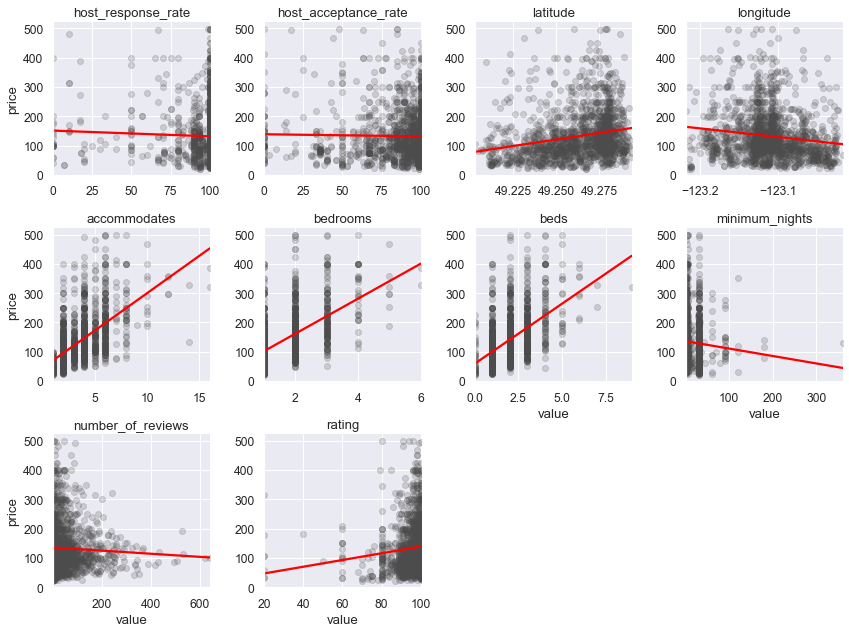

In [6]:
fig = air.plotting.reg_subplots(airbnb_train)

## Modelling

`airbnb_prediction` uses k-nearest neighbors regression to predict Airbnb nightly prices from our features. A key hyperparameter for this model is `k`. To find the best value of the hyperparameter `k` (number of nearest neighbours), we can split out data set into X (features) and y (target) subsets and then use the `analysis.k_optimization()` function to evaluate different values of `k` using cross-validation.



will perform 10-fold cross validation using root-mean-squared-error as our metric of model prediction performance.

Note that our input features are on different scales, e.g., latitude is in degrees and number of bedrooms is an integer. To allow our k-nearest neighbors model to equally weight features, we should scale the data before training. We'll use the `sklearn` function `MinMaxScaler()` to normalize our features to be between 0 and 1.

In [7]:
X_train, y_train, X_test, y_test = air.analysis.df_to_xy(airbnb_train.drop(columns=["host_response_rate", "host_acceptance_rate"]),
                                                     airbnb_test.drop(columns=["host_response_rate", "host_acceptance_rate"]),
                                                     normalize=True)

We'll explore model predictive performance on values of `k` from 1 to 30:

In [8]:
cv_results_df = air.analysis.k_optimization(X_train, y_train)
cv_results_df.sort_values(by="Mean", ignore_index=True).head(10)

,k,Mean,Min,Max
0,24,41.970845,36.810743,48.842118
1,21,41.996267,36.538153,48.732358
2,18,42.030654,36.097055,49.175368
3,25,42.032180,36.709157,49.023373
4,22,42.039393,36.386364,49.028204
5,20,42.040843,36.578313,48.860241
6,19,42.060309,36.726379,48.796449
7,15,42.067260,36.802008,49.832932
8,23,42.082694,36.670246,49.280513
9,10,42.085668,36.372892,50.562651


We'll use the `altair` library to make a plot of these results:

In [9]:
air.plotting.cv_results(cv_results_df)

alt.LayerChart(...)

## Results

Finally, we can get the performance of the model on the withheld test data. Ideally, the performance on the test set will be similar to the performance observed during cross-validation.

In [10]:
mae, model = air.analysis.test_model(X_train, y_train, X_test, y_test, k=10)
print(f"Test MAE: ${mae:.2f}")

Test MAE: $40.98
